# Importing the required modules

In [ ]:
# Modules used for data handling and manipulation
import numpy as np
import pandas as pd
import json

# Modules used for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

# Modules used for preprocessing
from sklearn.preprocessing import StandardScaler

# Modules used for time series forecasting
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Modules used for model evaluation
from sklearn.metrics import mean_absolute_percentage_error
import evaluation

# Modules used for preprocessing
from datetime import datetime, timedelta
import preprocess

# Modules used for object oriented programming
from abc import ABC, abstractmethod

# Module for suppressing warnings
import warnings 
warnings.filterwarnings('ignore')

# Consolidating the data

In [61]:
electricity = preprocess.preprocess_modelling(as_numpy=False, clustered=True, stationary=False)
temperature = preprocess.preprocess("temperature")
precipitation = preprocess.preprocess("precipitation")

In [62]:
electricity = electricity.drop(pd.to_datetime("2015-01-01"))

In [82]:
weather = pd.merge(temperature, precipitation, on='date', how='inner').set_index("date")

In [64]:
weather = temperature.set_index("date")

# Model template

In [120]:
# a model template for standardized evaluation
# of forecasts
class Model(ABC):
   def __init__(self, data, cluster: str, window_stride = 28):
      """
         The constructor for the abstract class Model for standardize evaluation

         Args:
            data: the actual time series that needs to be predicted.
            cluster: the cluster data which needs to be used (cluster_1 or cluster_0).
            window_stride: the stride (in days) for moving the train-test window; defaults to 28 days.

         Returns:
            - An object of abstract class Model.
      """
      # inputs
      self.data = data
      self.cluster = cluster
      self.ts_window_stride = window_stride

      # member variables
      self.trained_model = None
      self.ts_train = 180
      self.ts_test = 5
      self.MAX_IDX = len(electricity)
      self.forecasts = dict()

   def __standardize(self, train, test):
      """
      Standardizes the train and test datasets based on the statistical properties of the train dataset.

      Args:
         train: the train dataset
         test: the test dataset

      Returns:
         - The train dataset standardized based on the statistical properties of the train dataset
         - The test dataset standardized based on the statistical properties of the train dataset
      """
      scaler = StandardScaler()

      train_ = pd.DataFrame(scaler.fit_transform(train), 
                            columns=train.columns,
                            index = train.index)

      test_ = pd.DataFrame(scaler.transform(test), 
                           columns=test.columns,
                           index = test.index)
      
      return train_, test_
   
   # an abstract method for training the required model
   @abstractmethod
   def train_model(self, train, train_idx):
      pass

   # an abstract method for getting the forecasts from the model
   @abstractmethod
   def get_forecasts(self, test, test_idx):
      pass
   
   # cross validates the model based on the train-test split moving windows
   def cross_validate(self):

      # initial split for train and test
      train_idx = [0, self.ts_train]
      test_idx = [self.ts_train, self.ts_train + self.ts_test]

      # continuing for 50 such splits
      for split_id in range(50):
         # train and test data for the split
         train = self.data[train_idx[0]: train_idx[1]][[self.cluster]]
         test = self.data[test_idx[0]: test_idx[1]][[self.cluster]]

         # standardizing the train and test data
         train, test = self.__standardize(train, test)

         # training the model
         self.trained_model = self.train_model(train, train_idx)

         # getting the forecasts
         preds = self.get_forecasts(test, test_idx)
         self.forecasts[split_id] = {"pred": list(preds.values),
                                     "train_date_range": train_idx,
                                     "test_date_range": test_idx}
   
         # computing mape based on the in-cluster values
         test_np = test.values.flatten()
         mape_by_forecast = np.abs((test_np - self.forecasts[split_id]["pred"])/(test_np))
         self.forecasts[split_id]["mape_by_forecast"] = mape_by_forecast

         # next train-test split indices
         train_idx = [train_idx[0] + self.ts_window_stride, 
                     min(train_idx[1] + self.ts_window_stride, 
                        self.MAX_IDX)]
         test_idx = [test_idx[0] + self.ts_window_stride, 
                     min(test_idx[1] + self.ts_window_stride, 
                        self.MAX_IDX)]
         
         # breaks the loop if test data indices go beyond the dataset
         if test_idx[0] > len(self.data):
            break
   
   # plots the MAPE for each forecast in the form of a boxplot
   def mape_boxplot_by_step(self):

      # getting the relevant data
      t = dict()
      for i in self.forecasts:
         t[i] = self.forecasts[i]["mape_by_forecast"]

      df = pd.DataFrame.from_dict(t, orient = "index")

      # plotting th boxplot
      sns.boxplot(df, orient = 'h', log_scale = True)
      plt.xlabel("log(Mean Absolute Percentage Error)")
      plt.ylabel("The ith forecast")
      plt.title(f"MAPE for each forecast across different train-test windows ({self.cluster})")
      plt.show()
   
   # Plotting the MAPE as a boxplot for each client
   def mape_boxplot_by_client(self, num_clients: int):

      """
      Plots the MAPE for each client considering the cluster predictions as individual client predictions

      Note: 
         - the individual client electricity consumption is standardized based on the train dataset for comparison.
         - the MAPE values cannot exceed 100
      
      Args:
         num_clients: the number of clients for which the evaluation needs to be done.
      """
      
      t = []
      with open("clusters.json", "r") as f:
            
            # extracting the individual clients in the cluster
            clusters = json.load(fp = f)
            cluster = clusters[self.cluster[-1]]

            # obtaining the individual client electricity consumption
            l = preprocess.preprocess_modelling(as_numpy = False, 
                                                clustered = False, 
                                                stationary = False)
            
            # computing MAPE based on each client in the cluster
            # for every train-test window
            for i in cluster:
               mape = []
               for j in self.forecasts:

                  # getting and standardizing the train and test data
                  train_start, train_end = self.forecasts[j]["train_date_range"]
                  test_start, test_end = self.forecasts[j]["test_date_range"]
                  train = l[[i]][train_start:train_end]
                  test = l[[i]][test_start:test_end]
                  train, test = self.__standardize(train, test)

                  # computing and storing the MAPE
                  m = mean_absolute_percentage_error(test, self.forecasts[j]["pred"])
                  mape.append(min(m, 100))
               
               t.append(mape)
            

            mape_ = dict(zip(cluster[0:num_clients], t))

            # plotting the boxplot
            sns.boxplot(pd.DataFrame.from_dict(mape_, orient="columns"),
                        log_scale=True, orient='h')

            plt.xlabel("log(Mean Absolute Percentage Error)")
            plt.ylabel("Clients in the cluster")
            plt.title(f"MAPE for {num_clients} client across different train-test windows ({self.cluster})")
            plt.show()
               

# SARIMAX

In [121]:
# class for SARIMAX model
class SARIMAX_model(Model):
    
    def __init__(self, data, exogs, cluster: str, window_stride = 28):
        """
         The constructor for the abstract class Model for standardize evaluation

         Args:
            data: the actual time series that needs to be predicted.
            exogs: the exogeneous variables particularly for SARIMAX.
            cluster: the cluster data which needs to be used (cluster_1 or cluster_0).
            window_stride: the stride (in days) for moving the train-test window; defaults to 28 days.

         Returns:
            - An object of abstract class SARIMA.
        """
        super().__init__(data, cluster, window_stride)
        self.exogs = exogs
    
    # trains the model
    def train_model(self, train, train_idx):
        model = SARIMAX(endog = train[self.cluster], 
                        exog = self.exogs[train_idx[0]: train_idx[1]], 
                        order = (1, 1, 1), 
                        seasonal_order = (1, 1, 0, 12))
        return model.fit()
    
    # obtains the forecasts for next five time steps
    def get_forecasts(self, test, test_idx):
        return self.trained_model.predict(start = self.data.index[test_idx[0]], 
                                        end = self.data.index[test_idx[0]] + timedelta(len(test) - 1),
                                        exog = self.exogs[test_idx[0]: test_idx[1]])

In [122]:
m = SARIMAX_model(electricity, weather, "cluster_1")

In [123]:
m.cross_validate()

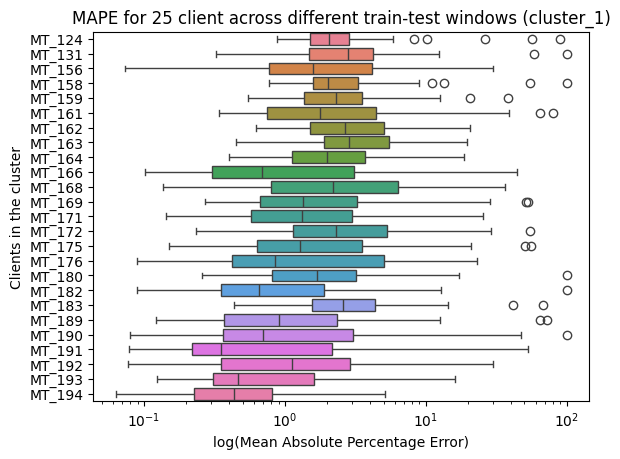

In [124]:
m.mape_boxplot_by_client(25)

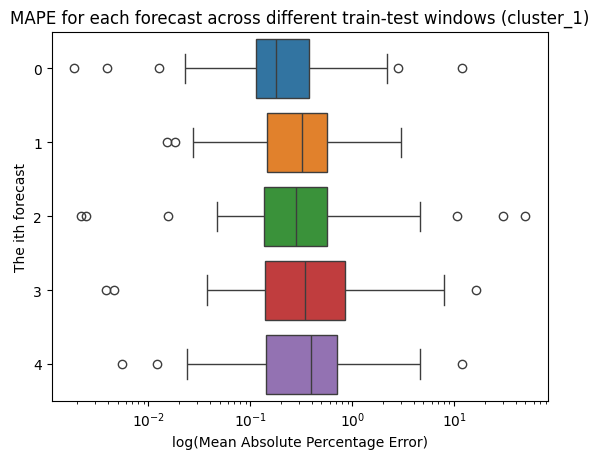

In [125]:
m.mape_boxplot_by_step()

In [126]:
m = SARIMAX_model(electricity, weather, "cluster_0")

In [127]:
m.cross_validate()

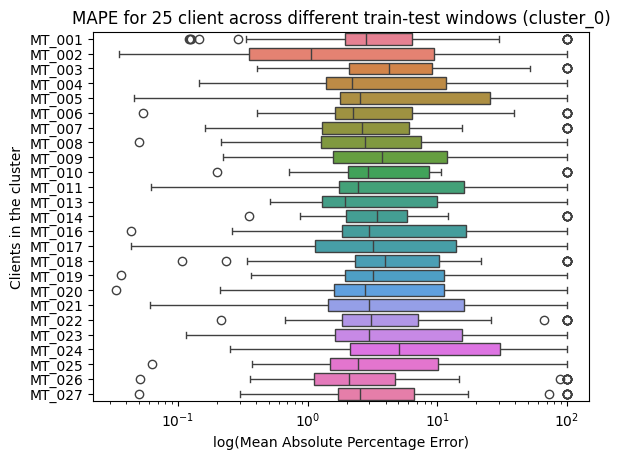

In [128]:
m.mape_boxplot_by_client(25)

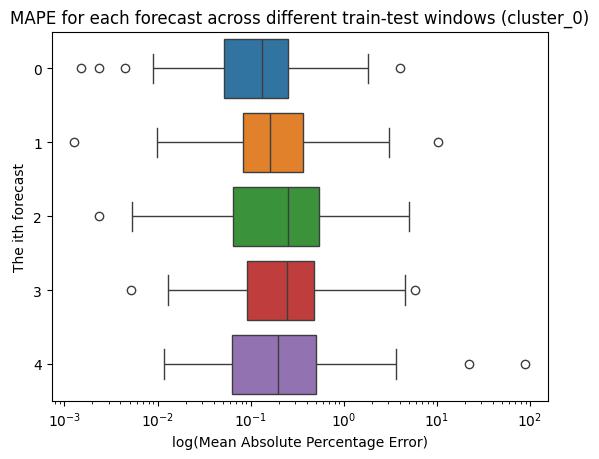

In [129]:
m.mape_boxplot_by_step()